In [141]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.lib import utils
from reportlab.pdfgen import canvas

from svglib.svglib import svg2rlg
from io import BytesIO
import time


class Peak(object):
    def __init__ (self,inRT,inWidth,inArea):
        self.RT = inRT
        self.Width = inWidth
        self.Area = inArea
    def getRT(self):
        return self.RT
    def getWidth(self):
        return self.Width
    def getArea(self):
        return self.Area
    
class UV_peak(Peak):
    def __init__(self,inRT,inWidth,inArea,inWavelength):
        self.Wavelength = inWavelength
        super(UV_peak,self).__init__(inRT,inWidth,inArea)
    def getWavelength(self):
        return self.Wavelength

class MS_peak(Peak):
    def __init__(self,inRT,inWidth,inArea,inMass):
        self.Mass = inMass
        super(MS_peak,self).__init__(inRT,inWidth,inArea)
    def getMass(self):
        return self.Mass

class FooterCanvas(canvas.Canvas):

    def __init__(self, *args, **kwargs):
        canvas.Canvas.__init__(self, *args, **kwargs)
        self.pages = []

    def showPage(self):
        self.pages.append(dict(self.__dict__))
        self._startPage()

    def save(self):
        page_count = len(self.pages)
        for page in self.pages:
            self.__dict__.update(page)
            self.draw_canvas(page_count)
            canvas.Canvas.showPage(self)
        canvas.Canvas.save(self)

    def draw_canvas(self, page_count):
        page = "Page %s of %s" % (self._pageNumber, page_count)
        x = 128
        datetime = time.strftime("%d-%b-%Y %H:%M", time.localtime())
        y = 80
        
        self.saveState()
        self.setStrokeColorRGB(0, 0, 0)
        self.setLineWidth(0.5)
        self.line(66, 78, A4[0] - 66, 78)
        self.setFont('Times-Roman', 10)
        self.drawString(A4[0]-x, 65, page)
        self.drawString(y,65,datetime)
        self.restoreState()
    
class Cal_sample(object):
    def __init__(self,inUVPeaks:list,inName,inDescription,inInjVol,inMethod,inMSPeaks:list = None, conc=None): #conc: mM
        self.UV_Peaks = inUVPeaks #inUVPeaks: list of UV_peak
        
        if (inMSPeaks == None):
            self.Has_MS = False
        else:
            self.Has_MS = True
            self.MS_Peaks = inMSPeaks
        self.Sample_Name = inName
        self.Description = inDescription
        self.Injection_Vol = inInjVol
        self.Method = inMethod
        
        self.wavelengthDic={}
        for i in range(0,len(self.UV_Peaks)):
            #print(self.UV_Peaks[i].getWavelength())
            self.wavelengthDic[self.UV_Peaks[i].getWavelength()] = i
        if (conc!=None):
            self.Concentration = conc
    
    
    def addConc(self,conc):
        self.Concentration = conc
        
    def addSMILES(self, smiles):
        self.smiles = smiles
        
    def addintStd(self,intStd):
        self.intStd = intStd
    
    def getConc(self):
        return self.Concentration
    
    def getPeakAtWavelength(self, wavelength):
        #print(self.wavelengthDic)
        if (wavelength in self.wavelengthDic):
            return self.UV_Peaks[self.wavelengthDic[wavelength]]
        else:
            return False
        
    def getPeakAtMass(self,mass):
        if self.Has_MS == False:
            return False
        for i in self.MS_Peaks:
            if abs(i.getMass()-mass)<=0.5:
                return i
        return False
    
    def getWavelengths(self):
        return self.wavelengthDic.keys()
    
    def getName(self):
        return self.Sample_Name
    def getDescription(self):
        return self.Description
    def getInjVol(self):
        return self.Injection_Vol
    def getUVPeaks(self):
        return self.UV_Peaks
    
    def append_UVPeak(self,appendPeak:UV_peak):
        self.UV_Peaks.append(appendPeak)
        self.wavelengthDic[appendPeak.getWavelength()]=len(self.UV_Peaks)-1
        
    def append_MSPeak(self,appendPeak:MS_peak):
        if (self.Has_MS == False):
            self.Has_MS = True
            self.MS_Peaks = [appendPeak]
        else:
            self.MS_Peaks.append(appendPeak)
            
class Compound(object):
    
    MethodWavelengths=[254,220,210,230,280]
    def __init__(self,inName : str, inFormula : str, inMass : float):
        
        self.Compound_name = inName
        self.Formula = inFormula
        self.Mass = inMass
        self.Sample_list = []
        self.intcalibrated = False
        
    def addIntStdInfo(self, slope, intercept, conc):
        self.intStd_slope = slope
        self.intStd_intercept = intercept
        self.intStd_conc = conc
        
    def __findInfo(self,df,content):
        dfnp=df.to_numpy()
        npwh=np.where(dfnp==content)
        whrow=npwh[0][0]
        row=dfnp[npwh[0][0]][npwh[1][0]+1:]
        whcol=np.where(row!='')[0][0]
        return row[whcol]
    
    def sortbyConc(self):
        self.Sample_list = sorted(self.Sample_list, key = lambda x : x.getConc())
    
    def getSamples(self):
        return self.Sample_list
    
    def getSampleNumber(self):
        return len(self.Sample_list)
    
    def getSampleNames(self):
        tmpList=[]
        for i in self.Sample_list:
            tmpList.append(i.getName())
        return tmpList
    
    def __pltToImg(self,fig,scaling_factor=0.45):
        imgdata = BytesIO()
        fig.savefig(imgdata, format='svg')
        imgdata.seek(0)  # rewind the data

        drawing=svg2rlg(imgdata)
        scaling_x = scaling_factor
        scaling_y = scaling_factor

        drawing.width = drawing.minWidth() * scaling_x
        drawing.height = drawing.height * scaling_y
        drawing.scale(scaling_x, scaling_y)

        return drawing

    
    def generateRpt(self,linRangeDict : dict = {}, infitLine = True,scale = "linear", intCal = False):
        self.plotData(fitLine = infitLine, linRangeDict = linRangeDict, inscale = scale, intCal = intCal)
        doc = SimpleDocTemplate("Calibration for "+self.Compound_name+".pdf",pagesize=A4,
                        rightMargin=72,leftMargin=72,
                        topMargin=72,bottomMargin=18,title = self.Compound_name)
        doc.topMargin = 0.8*inch
        doc.bottomMargin = 0.8*inch
        doc.leftMargin = 0.8*inch
        doc.rightMargin = 0.8*inch
        Story=[]

        styles=getSampleStyleSheet()
        styleH = styles['Heading1']
        styleH.alignment = 1
        Story.append(Paragraph("Calibration for "+self.Compound_name,styleH))
        Story.append(Spacer(8*inch,0.2 * inch))
        
        
        polylines_list = self.figures
        
        interval = 2

        polyline_set = []

        if (len(polylines_list) % 2 == 0):
            for idx in range(0, len(polylines_list), 2):
                
                polyline_set.append([self.__pltToImg(polylines_list[idx]), self.__pltToImg(polylines_list[idx + 1])])
        else:
            for idx in range(0, len(polylines_list)-1, 2):
                polyline_set.append([self.__pltToImg(polylines_list[idx]),self.__pltToImg( polylines_list[idx + 1])])
            polyline_set.append([self.__pltToImg(polylines_list[-1]), None])
            
            
        Story.append(Table(polyline_set))  
        Story.append(Spacer(8*inch,0.2 * inch))
        Story.append(Paragraph("Compound Name: "+self.Compound_name,styles['Normal']))
        Story.append(Paragraph("Molecular Mass: "+str(self.Mass),styles['Normal']))
        
        
        Story.append(Paragraph("Acq. method: "+self.Method,styles['Normal']))
        Story.append(Paragraph("Injection Volume: "+self.getSamples()[0].Injection_Vol + "μl",styles['Normal']))
        
        if(intCal == True):
            Story.append(Paragraph("With Internal Standard: " + str(self.intStd_conc) +"mM"))
        #if(self.skipSamples != None):
         #   Story.append(Paragraph("Skip Samples: " + ''.join(self.skipSamples)))
        doc.multiBuild(Story, canvasmaker=FooterCanvas)
        #doc.build(Story)

        print("Built successfully: Calibration for "+self.Compound_name+".pdf")

    def getAreaListMS(self, intCal = False):
        tmpListConc = []
        tmpListArea = []
        calNum = 1
        
        for i in self.Sample_list:
            if (i.getPeakAtMass(self.Mass)):
                if (intCal == True):
                    calNum = ((i.intStd.getArea() - self.intStd_intercept) / self.intStd_slope)/self.intStd_conc
                    #print(i.getName(),str(wavelength)+"nm", calNum,i.getConc())
                
                tmpListConc.append(i.getConc()*calNum)
                tmpListArea.append(i.getPeakAtMass(self.Mass).getArea())
                
        
        return [tmpListConc,tmpListArea]
    
    def plotMS_overlap(self,fitLine = False, linRange: list = None, intCal = False, plotrange=None):
        
        self.sortbyConc()
        tmplist=np.array(self.getAreaListMS(intCal = intCal))
        #print(tmplist)
        if(len(tmplist[0])==0):
            print("NO MS data")
        tmpfig = plt.figure(1)
            
            #self.figures.append(tmpfig)
            
        lower=0
        upper=len(tmplist[0])
        
        plower = 0
        pupper = len(tmplist[0])
        if plotrange != None:
            plower=np.argwhere(tmplist[0]>plotrange[0])[0][0]
            pupper=np.argwhere(tmplist[0]<plotrange[1])[-1][0]+1
        
        
        if linRange!=None:
            lower=np.argwhere(tmplist[0]>linRange[0])[0][0]
            upper=np.argwhere(tmplist[0]<linRange[1])[-1][0]+1
            #print (lower,upper)
            plt.vlines([tmplist[0][lower],tmplist[0][upper-1]],0,tmplist[1][pupper-1],linestyle='--')
            plt.text(tmplist[0][lower],0,str(round(tmplist[0][lower],5)))
            plt.text(tmplist[0][upper-1],0,str(round(tmplist[0][upper-1],5)))

        #print(tmplist)
        return (tmplist[0][plower:pupper],tmplist[1][plower:pupper])
        plt.plot(tmplist[0][plower:pupper],tmplist[1][plower:pupper],marker='o',linestyle='',label = self.Compound_name)
        
        plt.title(self.Compound_name+' '+str(self.Mass)+'Amu')
        plt.xlabel('Concentration / mM')
        plt.ylabel('Area')
        #fitting
        fitline=np.polyfit(tmplist[0][lower:upper],tmplist[1][lower:upper],1,cov=True)
        #print(fitline[0],fitline[1])
        slope=fitline[0][0]
        intercept=fitline[0][1]
        if(fitLine == True):
            plt.plot(np.array(tmplist[0][plower:pupper]),np.array(tmplist[0][plower:pupper])*slope+intercept)
            plt.text(tmplist[0][0],tmplist[1][pupper-1]*0.9,'Slope = '+str(round(slope,2))+'\nIntercept='+str(round(intercept,2)))
            print('Slope = '+str(round(slope,2))+'\nIntercept='+str(round(intercept,5)))
        
        
        #plt.show()
    
    
    
    def plotMS(self, fitLine = False, linRange: list = None, intCal = False, plotrange=None):
        
        self.sortbyConc()
        tmplist=np.array(self.getAreaListMS(intCal = intCal))
        print(tmplist)
        if(len(tmplist[0])==0):
            print("NO MS data")
        tmpfig = plt.figure(1)
            
            #self.figures.append(tmpfig)
            
        lower=0
        upper=len(tmplist[0])
        
        plower = 0
        pupper = len(tmplist[0])
        if plotrange != None:
            plower=np.argwhere(tmplist[0]>plotrange[0])[0][0]
            pupper=np.argwhere(tmplist[0]<plotrange[1])[-1][0]+1
        
        
        if linRange!=None:
            lower=np.argwhere(tmplist[0]>linRange[0])[0][0]
            upper=np.argwhere(tmplist[0]<linRange[1])[-1][0]+1
            #print (lower,upper)
            plt.vlines([tmplist[0][lower],tmplist[0][upper-1]],0,tmplist[1][pupper-1],linestyle='--')
            plt.text(tmplist[0][lower],0,str(round(tmplist[0][lower],5)))
            plt.text(tmplist[0][upper-1],0,str(round(tmplist[0][upper-1],5)))

        #print(tmplist)
        plt.plot(tmplist[0][plower:pupper],tmplist[1][plower:pupper],marker='o',linestyle='')
        plt.title(self.Compound_name+' '+str(self.Mass)+'Amu')
        plt.xlabel('Concentration / mM')
        plt.ylabel('Area')
        #fitting
        fitline=np.polyfit(tmplist[0][lower:upper],tmplist[1][lower:upper],1,cov=True)
        #print(fitline[0],fitline[1])
        slope=fitline[0][0]
        intercept=fitline[0][1]
        if(fitLine == True):
            plt.plot(np.array(tmplist[0][plower:pupper]),np.array(tmplist[0][plower:pupper])*slope+intercept)
            plt.text(tmplist[0][0],tmplist[1][pupper-1]*0.9,'Slope = '+str(round(slope,2))+'\nIntercept='+str(round(intercept,2)))
            print('Slope = '+str(round(slope,2))+'\nIntercept='+str(round(intercept,5)))
        
        
        plt.show()
    
    
    def plotData(self, wavelengths = MethodWavelengths, fitLine = False, linRangeDict: dict = {}, inscale = "linear", intCal = False):
        
        self.figures=[]
        self.sortbyConc()
        for i in range(0,len(wavelengths)):
            tmplist=np.array(self.getAreaList(wavelengths[i],intCal = intCal))
            if(len(tmplist[0])==0):
                continue
            tmpfig = plt.figure(i)
            
            self.figures.append(tmpfig)
            
            lower=0
            upper=len(tmplist[0])
            if wavelengths[i] in linRangeDict:
                linRange = linRangeDict[wavelengths[i]]
                lower=np.argwhere(tmplist[0]>linRange[0])[0][0]
                upper=np.argwhere(tmplist[0]<linRange[1])[-1][0]+1
                #print (lower,upper)
                plt.vlines([tmplist[0][lower],tmplist[0][upper-1]],0,tmplist[1][-1],linestyle='--')
                plt.text(tmplist[0][lower],0,str(round(tmplist[0][lower],2)))
                plt.text(tmplist[0][upper-1],0,str(round(tmplist[0][upper-1],2)))
                print(wavelengths[i], str(round(tmplist[0][lower],2)), str(round(tmplist[0][upper-1],2)))
                
            plt.xscale(inscale)
            plt.yscale(inscale)
            plt.plot(tmplist[0],tmplist[1],marker='o',linestyle='')
            plt.title(self.Compound_name+' '+str(wavelengths[i])+'nm')
            plt.xlabel('Concentration / mM')
            plt.ylabel('Area')
            #fitting
            fitline=np.polyfit(tmplist[0][lower:upper],tmplist[1][lower:upper],1,cov=True)
            #print(fitline[0],fitline[1])
            slope=fitline[0][0]
            intercept=fitline[0][1]
            plt.text(tmplist[0][0]+(tmplist[0][-1]-tmplist[0][0])*0.1,tmplist[1][-1]*0.9,'Slope = '+str(round(slope,2))+'\nIntercept='+str(round(intercept,2)))
            plt.plot(np.array(tmplist[0]),np.array(tmplist[0])*slope+intercept)
        
        plt.show()

    def plotDataOverlap(self, wavelengths = MethodWavelengths, fitLine = False, linRangeDict: dict = {}, inscale = "linear", intCal = False):
        
        self.figures=[]
        self.sortbyConc()
        for i in range(0,len(wavelengths)):
            tmplist2=np.array(self.getAreaList(wavelengths[i],intCal = None))
            tmplist=np.array(self.getAreaList(wavelengths[i],intCal = True))
            
            if(len(tmplist[0])==0):
                continue
            tmpfig = plt.figure(i)
            
            self.figures.append(tmpfig)
            
            lower=0
            upper=len(tmplist[0])
            if wavelengths[i] in linRangeDict:
                linRange = linRangeDict[wavelengths[i]]
                lower=np.argwhere(tmplist[0]>linRange[0])[0][0]
                upper=np.argwhere(tmplist[0]<linRange[1])[-1][0]+1
                #print (lower,upper)
                plt.vlines([tmplist[0][lower],tmplist[0][upper-1]],0,tmplist[1][-1],linestyle='--')
                plt.text(tmplist[0][lower],0,str(round(tmplist[0][lower],2)))
                plt.text(tmplist[0][upper-1],0,str(round(tmplist[0][upper-1],2)))
                
            plt.xscale(inscale)
            plt.yscale(inscale)
            
            plt.plot(tmplist[0],tmplist[1],marker='o',linestyle='')
            plt.plot(tmplist2[0],tmplist2[1],marker='x',linestyle='')
            
            plt.title(self.Compound_name+' '+str(wavelengths[i])+'nm')
            plt.xlabel('Concentration / mM')
            plt.ylabel('Area')
            #fitting
            fitline=np.polyfit(tmplist[0][lower:upper],tmplist[1][lower:upper],1,cov=True)
            #print(fitline[0],fitline[1])
            slope=fitline[0][0]
            intercept=fitline[0][1]
            plt.text(tmplist[0][0]+(tmplist[0][-1]-tmplist[0][0])*0.1,tmplist[1][-1]*0.9,'Slope = '+str(round(slope,2))+'\nIntercept='+str(round(intercept,2)))
            if fitLine == True:
                plt.plot(np.array(tmplist[0]),np.array(tmplist[0])*slope+intercept)
        
        plt.show()

        
    def getAreaList(self,wavelength, intCal = False) -> list:
        tmpListConc = []
        tmpListArea = []
        calNum = 1
        
        for i in self.Sample_list:
            if (i.getPeakAtWavelength(wavelength)):
                if (intCal == True):
                    calNum = ((i.intStd.getArea() - self.intStd_intercept) / self.intStd_slope)/self.intStd_conc
                    #print(i.getName(),str(wavelength)+"nm", calNum,i.getConc())
                
                tmpListConc.append(i.getConc()*calNum)
                tmpListArea.append(i.getPeakAtWavelength(wavelength).getArea())
        return [tmpListConc,tmpListArea]

    def loadSheet(self,df,skipBlank = True,intStd = None, intStdWavelength = 254, skipSample : list = None): #df: Dataframe of one sheet
        #print(self.__findInfo(df,'Sample name:'))
        name = self.__findInfo(df,'Sample name:').strip()
        if skipSample != None:
            if (name in skipSample):
                print("Skip sample: " + name)
                return
        self.intStdWavelength = intStdWavelength
        #print(name)
        
        if (name.lower()=='blank' and skipBlank):
            return
        
        try:
            description = self.__findInfo(df,'Description:')
        except IndexError:
            print("No description for: "+ name)
            description = 'None'
        
        volume = self.__findInfo(df,'Injection volume:')
        method = self.__findInfo(df,'Acq. method:')
        
        signal_loc = df[df.iloc[:,0]=='Signal:'].index.tolist()
        signal_loc.append(len(df))
        
        tmpPeaklist=[]
        MSlisttmp=[]
        
        intStdPeak = None
        
        if(intStd == None):
            for i in range(0,len(signal_loc)-1):
                peakdf=df.iloc[signal_loc[i]:signal_loc[i+1]]
                signalRow=peakdf.iloc[0,2]
                if(signalRow.find('DAD')!=-1):
                    wavelength=int(re.match('(.*), Sig=([0-9]*),.*',signalRow).group(2))
                    rtloc=peakdf.iloc[1].tolist().index('RT [min]')
                    RT = float(peakdf.iloc[2,rtloc])
                    #print(peakdf.iloc[:,rtloc])

                    widloc=peakdf.iloc[1].tolist().index('Width [min]')
                    Width = float(peakdf.iloc[2,widloc]) #Width

                    arealoc=peakdf.iloc[1].tolist().index('Area')
                    Area = float(peakdf.iloc[2,arealoc])#Area

                    tmpPeaklist.append(UV_peak(RT,Width,Area,wavelength))
                    
                if(signalRow.find('MSD1')!=-1 and signalRow.find('TIC') == -1):
                    masstmp = re.match('(.*)EIC=(.*):(.*)',signalRow).group(2)
                    
                    rtloc=peakdf.iloc[1].tolist().index('RT [min]')
                    RT = float(peakdf.iloc[2,rtloc])
                    
                    widloc=peakdf.iloc[1].tolist().index('Width [min]')
                    Width = float(peakdf.iloc[2,widloc]) #Width

                    arealoc=peakdf.iloc[1].tolist().index('Area')
                    Area = float(peakdf.iloc[2,arealoc])#Area
                    
                    MSlisttmp.append(MS_peak(RT,Width,Area,float(masstmp)))

                    
                    
        else:
            for i in range(0,len(signal_loc)-1):
                peakdf=df.iloc[signal_loc[i]:signal_loc[i+1]]
                signalRow=peakdf.iloc[0,2]
                if(signalRow.find('DAD')!=-1):
                    wavelength=int(re.match('(.*), Sig=([0-9]*),.*',signalRow).group(2))
                    for i in range(2,len(peakdf.iloc[:,peakdf.iloc[1].tolist().index('RT [min]')])-1):
                        rtloc=peakdf.iloc[1].tolist().index('RT [min]')
                        
                        if (peakdf.iloc[i,rtloc] == ''):
                            break
                        RT = float(peakdf.iloc[i,rtloc])
                        #print(peakdf.iloc[:,rtloc])

                        widloc=peakdf.iloc[1].tolist().index('Width [min]')
                        Width = float(peakdf.iloc[i,widloc]) #Width

                        arealoc=peakdf.iloc[1].tolist().index('Area')
                        Area = float(peakdf.iloc[i,arealoc])#Area

                        if (RT<intStd[0] or RT > intStd[1]):
                            tmpPeaklist.append(UV_peak(RT,Width,Area,wavelength))
                            #print(RT,Area)
                        else:
                            if (wavelength == intStdWavelength):
                                intStdPeak = UV_peak(RT,Width,Area,wavelength)
                if(signalRow.find('MSD1')!=-1 and signalRow.find('TIC') == -1):
                    masstmp = re.match('(.*)EIC=(.*):(.*)',signalRow).group(2)
                    
                    rtloc=peakdf.iloc[1].tolist().index('RT [min]')
                    RT = float(peakdf.iloc[2,rtloc])
                    
                    widloc=peakdf.iloc[1].tolist().index('Width [min]')
                    Width = float(peakdf.iloc[2,widloc]) #Width

                    arealoc=peakdf.iloc[1].tolist().index('Area')
                    Area = float(peakdf.iloc[2,arealoc])#Area
                    
                    MSlisttmp.append(MS_peak(RT,Width,Area,float(masstmp)))
                    print(RT,masstmp,Area,name)

        
        #print(MSlisttmp)
        if(MSlisttmp == []):
            MSlisttmp = None
        
        self.Sample_list.append(Cal_sample(tmpPeaklist,name,description,volume,method,inMSPeaks = MSlisttmp))
        self.Sample_list[-1].addintStd(intStdPeak)
        #print(intStdPeak.getRT(),intStdPeak.getWavelength())
        self.Method = method
        
    
    def loadReport(self, filename, skipBlank = True,intStd = None, intStdWavelength = 254, skipSample : list = None):
        self.skipSamples = skipSample
        xlsReport = pd.ExcelFile(filename)
        sheetList = xlsReport.sheet_names
        for i in sheetList:
            sheet=pd.read_excel(filename,engine='xlrd',skiprows=1,keep_default_na=False,sheet_name=i)
            self.loadSheet(sheet, skipBlank,intStd, intStdWavelength, skipSample = skipSample)
    
    def loadConc(self,filename,sheet=0,colName = 'Concentration'):
        rinput=pd.read_excel(filename,sheet,keep_default_na=False,index_col=0)
        rdata=pd.DataFrame(rinput)
        for i in self.Sample_list:
            try:
                #print(i.getName())
                i.addConc(rdata.loc[i.getName(),colName])
            except KeyError:
                print("Name not found: "+i.getName())
            

WARNING *** file size (487271) not 512 + multiple of sector size (512)
WARNING *** file size (487271) not 512 + multiple of sector size (512)
WARNING *** file size (487271) not 512 + multiple of sector size (512)
2.607 171.7 2232232.75 A11-1
2.605 172.7 87217.8984 A11-1
WARNING *** file size (487271) not 512 + multiple of sector size (512)
2.564 171.7 150395.8281 A11-2
2.583 172.7 3764.1919 A11-2
WARNING *** file size (487271) not 512 + multiple of sector size (512)
2.573 171.7 827435.25 A11-3
2.572 172.7 43824.1445 A11-3
WARNING *** file size (487271) not 512 + multiple of sector size (512)
2.565 171.7 471532.7188 A11-4
2.526 172.7 1403.672 A11-4
WARNING *** file size (487271) not 512 + multiple of sector size (512)
2.57 171.7 298858.3438 A11-5
2.574 172.7 21515.8086 A11-5
WARNING *** file size (487271) not 512 + multiple of sector size (512)
2.564 171.7 180053.1094 A11-6
2.569 172.7 9226.5684 A11-6
WARNING *** file size (487271) not 512 + multiple of sector size (512)
2.564 171.7 107

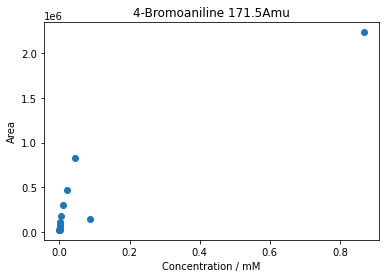

In [142]:
A11=Compound('4-Bromoaniline','BrC6H4NH2',171.5)

A11.loadReport('A11.xls', intStd = [3.3,3.6])
A11.loadConc('Amines_conc.xlsx',sheet='Sheet1',colName = 'conc(mM)')
A11.addIntStdInfo(25.4, -5.17, 10)
#test.generateRpt(intCal = True)
#test.plotDataOverlap()
#test.plotMS(intCal = True,plotrange=[0,0.05],linRange = [0.001,0.008],fitLine = True)
A11.plotMS(intCal = True,plotrange=[0,10])

WARNING *** file size (486001) not 512 + multiple of sector size (512)
WARNING *** file size (486001) not 512 + multiple of sector size (512)
WARNING *** file size (486001) not 512 + multiple of sector size (512)
2.309 121.9 14025337.0 A12-1
WARNING *** file size (486001) not 512 + multiple of sector size (512)
2.503 120.9 4888.52 A12-2
2.323 121.9 2106275.5 A12-2
WARNING *** file size (486001) not 512 + multiple of sector size (512)
2.532 120.9 1772.76 A12-3
2.323 121.9 3657869.75 A12-3
WARNING *** file size (486001) not 512 + multiple of sector size (512)
2.249 120.9 1230.8199 A12-4
2.31 121.9 1600434.5 A12-4
WARNING *** file size (486001) not 512 + multiple of sector size (512)
2.451 120.9 4203.7695 A12-5
2.33 121.9 879681.9375 A12-5
WARNING *** file size (486001) not 512 + multiple of sector size (512)
2.459 120.9 6811.9736 A12-6
2.322 121.9 479136.25 A12-6
WARNING *** file size (486001) not 512 + multiple of sector size (512)
2.279 120.9 2686.948 A12-7
2.312 121.9 242093.3281 A12-

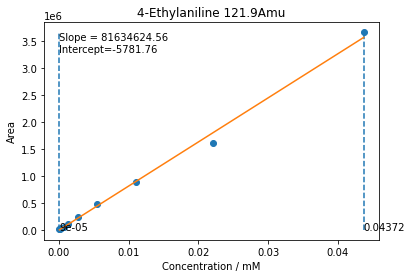

In [143]:
A12=Compound('4-Ethylaniline','C2H5C6H4NH2',121.9)

A12.loadReport('A12.xls', intStd = [3,3.6])
A12.loadConc('Amines_conc.xlsx',sheet='Sheet1',colName = 'conc(mM)')
A12.addIntStdInfo(25.4, -5.17, 10)
#test.generateRpt(intCal = True)
#test.plotDataOverlap()
#test.plotMS(intCal = True,plotrange=[0,0.05],linRange = [0.001,0.008],fitLine = True)
A12.plotMS(intCal = True,plotrange=[0,0.08],linRange = [0,0.06],fitLine = True)


WARNING *** file size (482564) not 512 + multiple of sector size (512)
WARNING *** file size (482564) not 512 + multiple of sector size (512)
WARNING *** file size (482564) not 512 + multiple of sector size (512)
0.552 108.8 8841.0479 A13-1
0.552 109.8 3515276.25 A13-1
WARNING *** file size (482564) not 512 + multiple of sector size (512)
0.552 109.8 622532.3125 A13-2
WARNING *** file size (482564) not 512 + multiple of sector size (512)
0.547 109.8 369496.2813 A13-3
WARNING *** file size (482564) not 512 + multiple of sector size (512)
0.552 109.8 216809.1875 A13-4
WARNING *** file size (482564) not 512 + multiple of sector size (512)
0.552 108.8 1491.204 A13-5
0.547 109.8 109733.8438 A13-5
WARNING *** file size (482564) not 512 + multiple of sector size (512)
0.552 108.8 1886.52 A13-6
0.547 109.8 73176.75 A13-6
WARNING *** file size (482564) not 512 + multiple of sector size (512)
0.547 109.8 30935.1367 A13-7
WARNING *** file size (482564) not 512 + multiple of sector size (512)
0.55

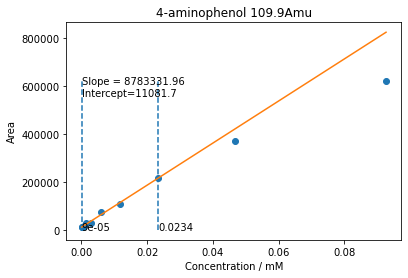

In [144]:
A13=Compound('4-aminophenol','H2NC6H4OH',109.9)

A13.loadReport('A13.xls', intStd = [3,3.6])
A13.loadConc('Amines_conc.xlsx',sheet='Sheet1',colName = 'conc(mM)')
A13.addIntStdInfo(25.4, -5.17, 10)
#test.generateRpt(intCal = True)
#test.plotDataOverlap()
#test.plotMS(intCal = True,plotrange=[0,0.05],linRange = [0.001,0.008],fitLine = True)
A13.plotMS(intCal = True,plotrange=[0,0.2],fitLine = True, linRange = [0,0.04])

WARNING *** file size (494551) not 512 + multiple of sector size (512)
WARNING *** file size (494551) not 512 + multiple of sector size (512)
WARNING *** file size (494551) not 512 + multiple of sector size (512)
0.439 107.8 4456.8638 A14-1
0.49 108.8 4987978.5 A14-1
WARNING *** file size (494551) not 512 + multiple of sector size (512)
0.458 107.8 11307.1123 A14-2
0.486 108.8 844687.6875 A14-2
WARNING *** file size (494551) not 512 + multiple of sector size (512)
0.447 107.8 8257.7119 A14-3
0.476 108.8 510265.4375 A14-3
WARNING *** file size (494551) not 512 + multiple of sector size (512)
0.447 107.8 5926.2642 A14-4
0.475 108.8 253887.8438 A14-4
WARNING *** file size (494551) not 512 + multiple of sector size (512)
0.442 107.8 7562.5122 A14-5
0.486 108.8 155642.3281 A14-5
WARNING *** file size (494551) not 512 + multiple of sector size (512)
0.463 107.8 2300.1548 A14-6
0.506 108.8 91399.8438 A14-6
WARNING *** file size (494551) not 512 + multiple of sector size (512)
0.446 107.8 8437

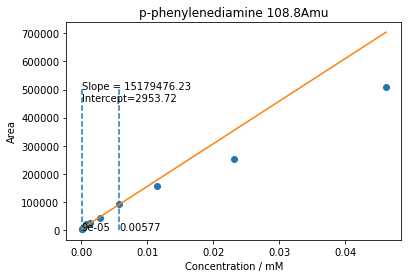

In [145]:
A14=Compound('p-phenylenediamine','C6H4(NH2)2',108.8)

A14.loadReport('A14.xls', intStd = [3,3.6])
A14.loadConc('Amines_conc.xlsx',sheet='Sheet1',colName = 'conc(mM)')
A14.addIntStdInfo(25.4, -5.17, 10)
#test.generateRpt(intCal = True)
#test.plotDataOverlap()
#test.plotMS(intCal = True,plotrange=[0,0.05],linRange = [0.001,0.008],fitLine = True)
A14.plotMS(intCal = True,plotrange=[0,0.08],linRange = [0,0.01],fitLine = True)

WARNING *** file size (490449) not 512 + multiple of sector size (512)
WARNING *** file size (490449) not 512 + multiple of sector size (512)
WARNING *** file size (490449) not 512 + multiple of sector size (512)
2.651 137.8 7627.7646 A16-1
2.503 138.8 1673105.875 A16-1
WARNING *** file size (490449) not 512 + multiple of sector size (512)
2.491 137.8 4298.8638 A16-2
2.504 138.8 317573.375 A16-2
WARNING *** file size (490449) not 512 + multiple of sector size (512)
2.49 137.8 6401.5278 A16-3
2.515 138.8 185503.375 A16-3
WARNING *** file size (490449) not 512 + multiple of sector size (512)
2.623 137.8 1325.6217 A16-4
2.502 138.8 100850.7656 A16-4
WARNING *** file size (490449) not 512 + multiple of sector size (512)
2.468 137.8 2287.5913 A16-5
2.51 138.8 54462.8477 A16-5
WARNING *** file size (490449) not 512 + multiple of sector size (512)
2.539 137.8 3547.416 A16-6
2.52 138.8 32994.8242 A16-6
WARNING *** file size (490449) not 512 + multiple of sector size (512)
0.051 137.8 2712.228 

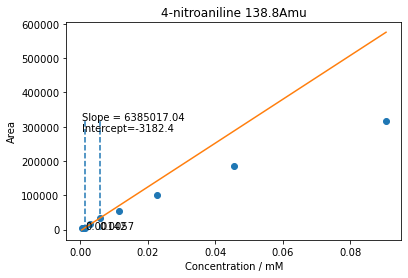

In [146]:
A16=Compound('4-nitroaniline','O2NC6H4NH2',138.8)

A16.loadReport('A16.xls', intStd = [3,3.6])
A16.loadConc('Amines_conc.xlsx',sheet='Sheet1',colName = 'conc(mM)')
A16.addIntStdInfo(25.4, -5.17, 10)
#test.generateRpt(intCal = True)
#test.plotDataOverlap()
#test.plotMS(intCal = True,plotrange=[0,0.05],linRange = [0.001,0.008],fitLine = True)
A16.plotMS(intCal = True,plotrange=[0,0.1],linRange = [0.001,0.01],fitLine = True)

WARNING *** file size (473839) not 512 + multiple of sector size (512)
WARNING *** file size (473839) not 512 + multiple of sector size (512)
WARNING *** file size (473839) not 512 + multiple of sector size (512)
0.861 111.8 5312060.0 A17-1
WARNING *** file size (473839) not 512 + multiple of sector size (512)
0.879 111.8 1034611.8125 A17-2
WARNING *** file size (473839) not 512 + multiple of sector size (512)
0.852 111.8 686674.625 A17-3
WARNING *** file size (473839) not 512 + multiple of sector size (512)
0.844 111.8 405949.125 A17-4
WARNING *** file size (473839) not 512 + multiple of sector size (512)
0.886 111.8 233323.8594 A17-5
WARNING *** file size (473839) not 512 + multiple of sector size (512)
0.849 111.8 125938.0547 A17-6
WARNING *** file size (473839) not 512 + multiple of sector size (512)
0.838 111.8 68869.3594 A17-7
WARNING *** file size (473839) not 512 + multiple of sector size (512)
0.817 111.8 35983.332 A17-8
WARNING *** file size (473839) not 512 + multiple of sec

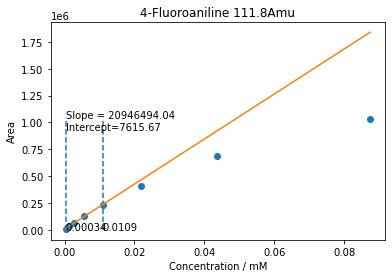

In [147]:
A17=Compound('4-Fluoroaniline','FC6H4NH2',111.8)

A17.loadReport('A17.xls', intStd = [3,3.6])
A17.loadConc('Amines_conc.xlsx',sheet='Sheet1',colName = 'conc(mM)')
A17.addIntStdInfo(25.4, -5.17, 10)
#test.generateRpt(intCal = True)
#test.plotDataOverlap()
#test.plotMS(intCal = True,plotrange=[0,0.05],linRange = [0.001,0.008],fitLine = True)
A17.plotMS(intCal = True,plotrange=[0,0.1],linRange = [0,0.02],fitLine = True)

WARNING *** file size (494399) not 512 + multiple of sector size (512)
WARNING *** file size (494399) not 512 + multiple of sector size (512)
WARNING *** file size (494399) not 512 + multiple of sector size (512)
2.608 160.8 2876.2319 A18-1
2.663 161.8 2063658.625 A18-1
WARNING *** file size (494399) not 512 + multiple of sector size (512)
2.618 160.8 4446.752 A18-2
2.66 161.8 285226.0313 A18-2
WARNING *** file size (494399) not 512 + multiple of sector size (512)
2.665 160.8 16794.7285 A18-3
2.664 161.8 187410.4375 A18-3
WARNING *** file size (494399) not 512 + multiple of sector size (512)
2.692 160.8 22967.4141 A18-4
2.674 161.8 105935.8438 A18-4
WARNING *** file size (494399) not 512 + multiple of sector size (512)
2.701 160.8 15823.083 A18-5
2.679 161.8 63203.8281 A18-5
WARNING *** file size (494399) not 512 + multiple of sector size (512)
2.66 160.8 22647.957 A18-6
2.672 161.8 35920.2695 A18-6
WARNING *** file size (494399) not 512 + multiple of sector size (512)
2.658 160.8 2944

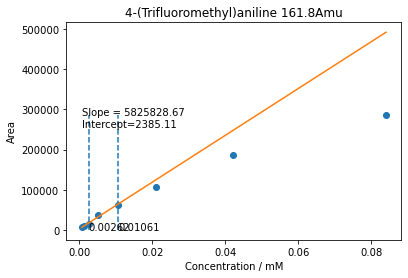

In [148]:
A18=Compound('4-(Trifluoromethyl)aniline','CF3C6H4NH2',161.8)

A18.loadReport('A18.xls', intStd = [3,3.6])
A18.loadConc('Amines_conc.xlsx',sheet='Sheet1',colName = 'conc(mM)')
A18.addIntStdInfo(25.4, -5.17, 10)
#test.generateRpt(intCal = True)
#test.plotDataOverlap()
#test.plotMS(intCal = True,plotrange=[0,0.05],linRange = [0.001,0.008],fitLine = True)
A18.plotMS(intCal = True,plotrange=[0,0.1],linRange = [0.002,0.02],fitLine = True)

4-aminophenol
p-phenylenediamine
4-nitroaniline
4-Fluoroaniline
4-(Trifluoromethyl)aniline


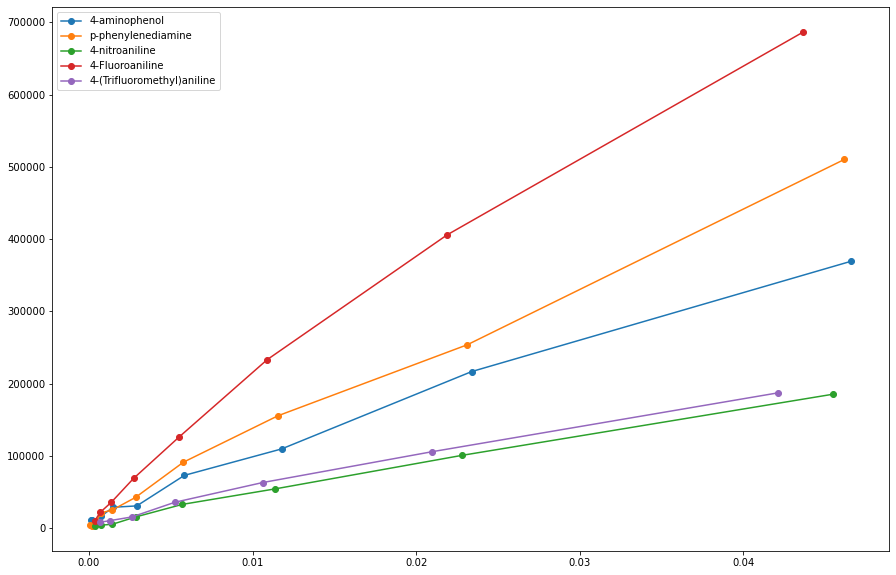

In [158]:
samples = [A13,A14,A16,A17,A18]
plt.figure(figsize = (15,10))
for i in samples:
    a,b = i.plotMS_overlap(intCal = True,plotrange=[0,0.05])
    plt.plot(a,b,linestyle = '-',marker = 'o',label = i.Compound_name)
    print (i.Compound_name)
plt.legend()
plt.show()